# <span style="color:red"> <strong> Collaborative Filtering System  </strong>

#### *<span style="font-family:Times New Roman; color: yellow">75% of what people are watching on Netflix comes from recommendations. --- McKinsey*

Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list suggestions.



### Problem Statement
Build a system that can automatically recommend items to users based on the preferences of other similar users. 

### The Dataset
To experiment with recommendation algorithms, you'll need data that contains a set of items and a set of users who have reacted to some of the items.
The reactions can be explicit (e.g., rating on a scale of 1-5, likes or dislikes) or implicit (e.g., viewing an item, adding it to a wish list, the time spent on an item). 
While working with such data, you'll mostly see it in the form of a matrix consisting of the reactions given by a set of users to some items from a set of items. Each row would contain the ratings given by a user, and each column would contain the ratings received by an item. 

In most cases, the cells in the matrix are empty, as users only rate a few items. It's highly unlikely for every user to rate or react to every item available. A matrix with mostly every cells is called `sparse`, and the opposite to that is called `dense`.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

movie_df  = pd.read_csv("../data/movie.csv")
rating_df = pd.read_csv("../data/rating.csv")
movie_rating = movie_df.merge(rating_df, how="inner", on="movieId")
movie_rating["timestamp"] = pd.DatetimeIndex(movie_rating["timestamp"])
movie_rating["year"] = movie_rating["timestamp"].dt.year
movie_rating

,movieId,title,genres,userId,rating,timestamp,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1999-12-11 13:36:47,1999
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,1997-03-13 17:50:52,1997
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,1996-06-05 13:37:51,1996
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,1999-11-25 02:44:47,1999
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,2009-01-02 01:13:41,2009
...,...,...,...,...,...,...,...
20000258,131254,Kein Bund für's Leben (2007),Comedy,79570,4.0,2015-03-30 19:32:59,2015
20000259,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,79570,4.0,2015-03-30 19:48:08,2015
20000260,131258,The Pirates (2014),Adventure,28906,2.5,2015-03-30 19:56:32,2015
20000261,131260,Rentun Ruusu (2001),(no genres listed),65409,3.0,2015-03-30 19:57:46,2015


As shown above, the dataframe tells what rating a user gave to a particular movie. This dataframe contains 20000263 such ratings.

### Algorithms

There are mainly two categories of algorithms can be applied: `Memory Based`  &  `Model Based`.

#### Memory Based

The first category includes algorithms that are memory based, in which statistical techniques are applied to the entire dataset to calculate the predictions.
To find the rating R that a user U would give to an item I, this approach includes:

- Step 1: find users similar to U who have rated the item I

- Step 2: calculte the rating R based on the ratings of users found in the previous step. For example:
  $R_U = (\sum_{u=1}^{N}R_u * S_u) / (\sum_{u=1}^{N}S_u)$, where $S_u$ is the similary factor for each user similar to the target user U and $R_u$ is the rating of each user similar to the target user U.

#### Model Based

In the user-item matrix, there are two dimensions: the number of users & the number of items

If the matrix is mostly empty, reducing dimensions can improve the performance of the algorithm in terms of both space and time. We can use method like `Matrix factorization` to do this. 

`Matrix factorization` can be seen as breaking down the user-item matrix(m x n) into the product of user matrix(m x p) and item matrix(p x n). The m rows in the first matrix represent the m users, and the p columns tell us about the features of the users. The same goes for the item matrix with n items and p features. One of the popular algorithms to factorize a matrix is the `Singular Value Decomposition`. SVD came into the limelight when matrix factorization was seen performing well in the Netflix prize competition. Other algorithms include `PCA` and its variants, `NMF`, Autoencoder, and so on.  


Now let's use library `Surprise` that comes with various recommender algorithms and similarity metrics to build and analyze a model-based recommender!

In [38]:
#%pip install scikit-surprise
#load data
data = movie_rating[["movieId", "userId", "rating"]]
data

,movieId,userId,rating
0,1,3,4.0
1,1,6,5.0
2,1,8,4.0
3,1,10,4.0
4,1,11,4.5
...,...,...,...
20000258,131254,79570,4.0
20000259,131256,79570,4.0
20000260,131258,28906,2.5
20000261,131260,65409,3.0


In [27]:
#find duplicates
data.duplicated().sum()

0

In [63]:
# #split the data into train/test sets based on userIds
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2)

/var/folders/cf/3kbbttcn1g35qhk6ldvlg1lh0000gn/T/ipykernel_56280/570980266.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


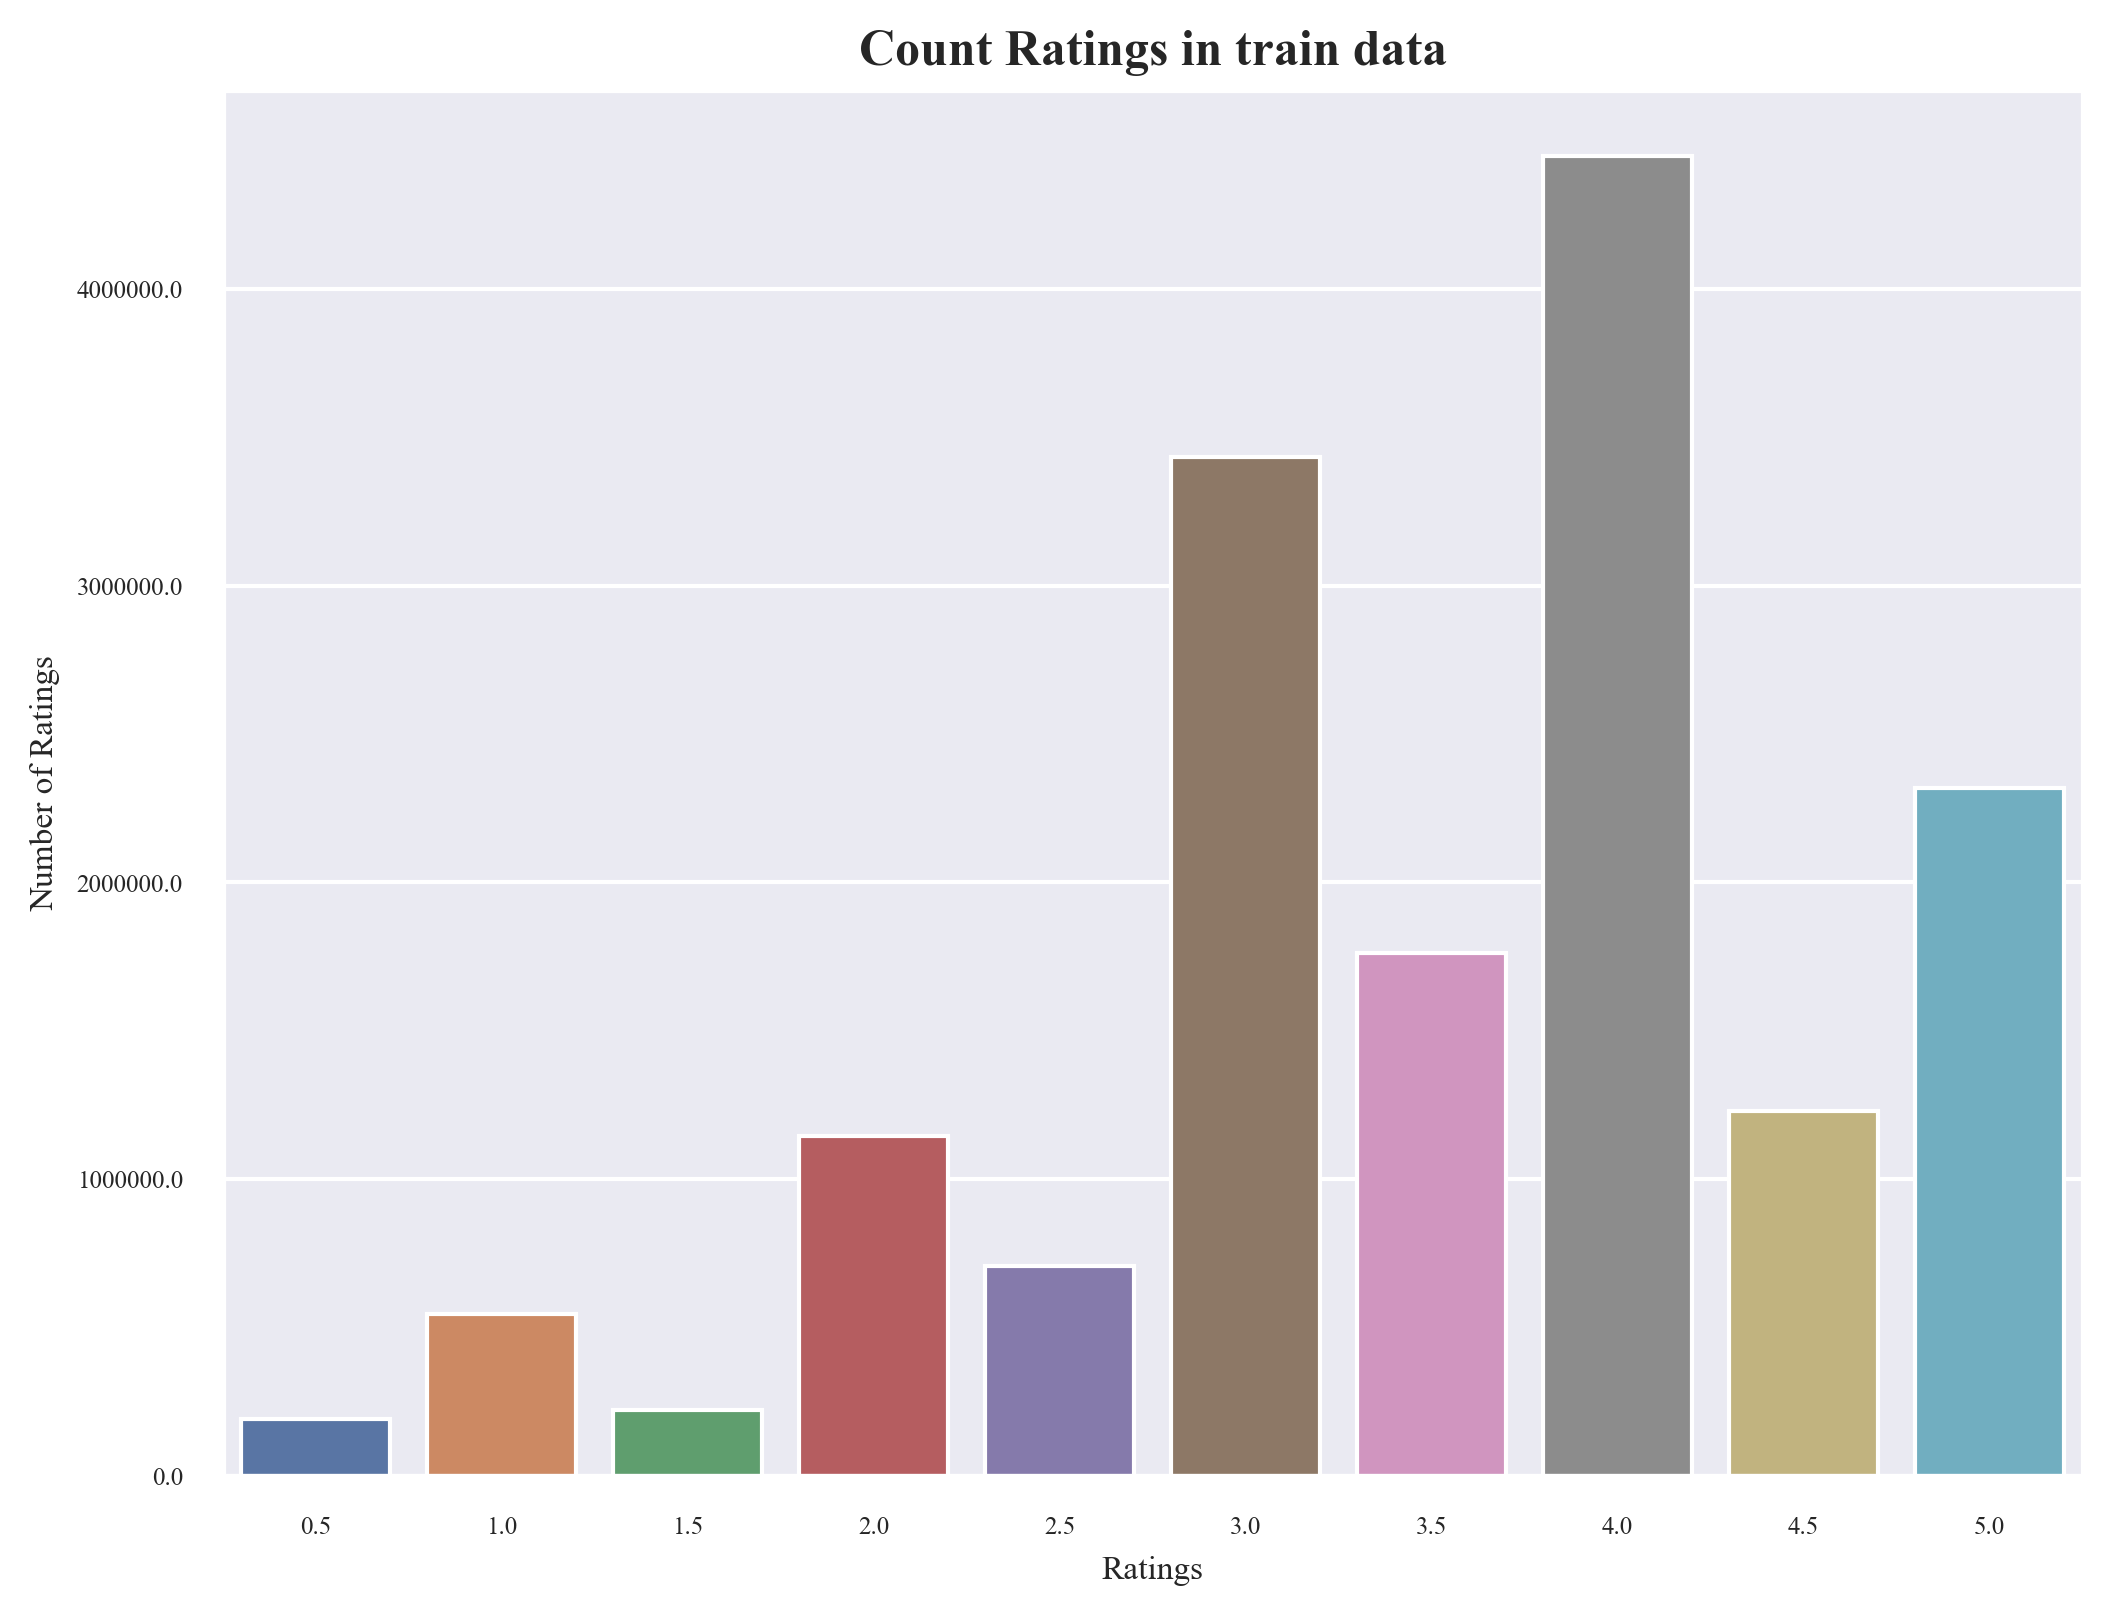

In [64]:
#count the number of ratings in the training dataset
plt.figure(figsize=(8,6), dpi=300)
sns.set(style="darkgrid")
sns.set(font="Times New Roman")
ax = sns.countplot(x="rating", data=train_data)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 6)
plt.title("Count Ratings in train data", fontsize = 12, weight="bold")
plt.xlabel("Ratings", fontsize = 8)
plt.ylabel("Number of Ratings", fontsize = 8)
plt.show()

### Implement a Model-based Recommendation System

In [93]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
reader = Reader()

In [95]:
#transform the dataset to be read in an appropriate format by SVD. We will use RMSE as the meaure to evaluate SVD's performance.
data2 = Dataset.load_from_df(train_data[["userId", "movieId", "rating"]], reader)
svd = SVD()
cross_validate(svd, data2, measures=["RMSE", "MAE"], cv=5) 

{'test_rmse': array([0.79800061, 0.79810324, 0.79794493, 0.79788619, 0.79888455]),
 'test_mae': array([0.60773219, 0.60806587, 0.60766859, 0.60817262, 0.60874402]),
 'fit_time': (264.4428038597107,
  244.34311389923096,
  245.56565499305725,
  233.1918363571167,
  233.93238878250122),
 'test_time': (64.18282532691956,
  52.44857478141785,
  56.89047622680664,
  51.222771883010864,
  47.16462683677673)}

In [96]:
trainset = data2.build_full_trainset()
svd.fit(trainset)

We have used cross-validation to train our recommender model using 5 folds - which basically means the whole dataset is iterated over 5 times - each time 4 parts of the dataset are used for training the model and one part for evaluating the recommender system. The `MAE` and `RMSE` is give for each iteration or fold. Let's choose a user and view all the movies this user has rated!

In [100]:
example_user = train_data[train_data["userId"]==136079]
example_user

,movieId,userId,rating
8271196,1598,136079,5.0
3419985,509,136079,3.0
8387063,1629,136079,3.0
3439824,515,136079,5.0
4940413,860,136079,4.0
8650669,1711,136079,5.0
8519619,1675,136079,5.0
8270123,1597,136079,3.0
8292976,1608,136079,3.0
5577189,1057,136079,2.0


In [102]:
svd.predict(136079, 1) #choose a user 136079 and predict the rating this user would give to movie 1 that he/she has never rated before.

Prediction(uid=136079, iid=1, r_ui=None, est=4.175235512828555, details={'was_impossible': False})

The system predicted that the user will rate the movie 1 with 4.2, which is in a sense within the limits in which this user rates movies. So, model-based collaborative methods try to accurately predict a user's preference for an item and then recommend items that a user would like based on the predicted ratings.

Pros of Model-based collaborative filtering:
- Easy to scale and can be used to work on super large datasets
- Overfitting can be avoided if the data on which we have trained is representative of the general population
- The prediction speed is much faster than memory-based models since we only query the model not the whole dataset
  
Cons of Model-based collaborative filtering:
- The quality of predictions is solely dependent on the quality of the model built
- It is not very intuitive 